In [52]:
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

In [54]:
# Load the datasets
ideal_data = pd.read_csv('Hackathon_Ideal_Data.csv')
working_data = pd.read_csv('Hackathon_Working_Data.csv')
validation_data = pd.read_csv('Hackathon_Validation_Data.csv')
sample_submission = pd.read_csv('Sample Submission.csv')


In [55]:
# Display the first few rows of each dataset
print("Ideal Data:")
print(ideal_data.head())

Ideal Data:
  MONTH STORECODE  QTY  VALUE                GRP               SGRP  \
0    M1        P1   25     83  HAIR CONDITIONERS  HAIR CONDITIONERS   
1    M1        P1    6     22  HAIR CONDITIONERS  HAIR CONDITIONERS   
2    M1        P1    4     15  HAIR CONDITIONERS  HAIR CONDITIONERS   
3    M1        P1   15     60  HAIR CONDITIONERS  HAIR CONDITIONERS   
4    M1        P2    0      0  HAIR CONDITIONERS  HAIR CONDITIONERS   

               SSGRP                         CMP         MBRD  \
0  HAIR CONDITIONERS  HINDUSTAN UNILEVER LIMITED         DOVE   
1  HAIR CONDITIONERS  HINDUSTAN UNILEVER LIMITED         DOVE   
2  HAIR CONDITIONERS  HINDUSTAN UNILEVER LIMITED         DOVE   
3  HAIR CONDITIONERS               L'OREAL INDIA      GARNIER   
4  HAIR CONDITIONERS  HINDUSTAN UNILEVER LIMITED  CLINIC PLUS   

                     BRD  
0  DOVE HAIR FALL RESCUE  
1    DOVE INTENSE REPAIR  
2   DOVE OXYGEN MOISTURE  
3                FRUCTIS  
4            CLINIC PLUS  


In [56]:
print("\nWorking Data:")
print(working_data.head())



Working Data:
  MONTH STORECODE  DAY BILL_ID  BILL_AMT  QTY  VALUE  PRICE  \
0    M1        N1    4    T375     225.0  1.0  225.0  225.0   
1    M1        N1    4    T379      95.0  1.0   95.0   95.0   
2    M1        N1    4    T381      10.0  1.0   10.0   10.0   
3    M1        N1    4    T382     108.0  1.0  108.0  108.0   
4    M1        N1    4    T384      19.0  1.0   19.0   19.0   

                       GRP                     SGRP                    SSGRP  \
0     BUTTER MARGR  (4/94)                   BUTTER                   SALTED   
1  CONFECTIONERY - ECLAIRS  CONFECTIONERY - ECLAIRS  CONFECTIONERY - ECLAIRS   
2                CHOCOLATE         CHOCOLATE PANNED         CHOCOLATE PANNED   
3             PACKAGED TEA               MAIN PACKS               MAIN PACKS   
4         ALL IODISED SALT            POWDERED SALT            POWDERED SALT   

                      CMP           MBRD                 BRD  
0               G C M M F           AMUL                AMUL  

In [57]:
print("\nValidation Data:")
print(validation_data.head())



Validation Data:
        ID STORECODE MONTH                       GRP
0  1112535        N1    M1       AFTER SHAVE LOTIONS
1  1112539        N1    M1    AGARBATTI & DHOOPBATTI
2  1112543        N1    M1  ALL AIR FRESHNERS(01/03)
3  1112547        N1    M1          ALL IODISED SALT
4  1112551        N1    M1                  ANTACIDS


In [58]:
# Check for missing values
print("\nMissing values in Ideal Data:")
print(ideal_data.isnull().sum())


Missing values in Ideal Data:
MONTH        0
STORECODE    0
QTY          0
VALUE        0
GRP          0
SGRP         0
SSGRP        0
CMP          0
MBRD         0
BRD          0
dtype: int64


In [59]:
print("\nMissing values in Working Data:")
print(working_data.isnull().sum())



Missing values in Working Data:
MONTH        0
STORECODE    0
DAY          0
BILL_ID      0
BILL_AMT     0
QTY          0
VALUE        0
PRICE        0
GRP          0
SGRP         0
SSGRP        0
CMP          0
MBRD         0
BRD          0
dtype: int64


In [60]:
print("\nMissing values in Validation Data:")
print(validation_data.isnull().sum())


Missing values in Validation Data:
ID           0
STORECODE    0
MONTH        0
GRP          0
dtype: int64


In [61]:
# Handling missing values using SimpleImputer (mean strategy)
imputer = SimpleImputer(strategy='mean')


In [62]:
#Impute missing values in the 'VALUE' column of working_data
working_data['VALUE'] = imputer.fit_transform(working_data[['VALUE']])


In [63]:
# Alternatively, you can fill missing data with forward fill for time series data
working_data.fillna(method='ffill', inplace=True)

<ipython-input-63-ac903d312b0e>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  working_data.fillna(method='ffill', inplace=True)


Exploratory Data Analysis (EDA)

In [64]:
# Grouping and aggregating data
monthly_sales = ideal_data.groupby(['MONTH', 'STORECODE'])['VALUE'].sum().reset_index()

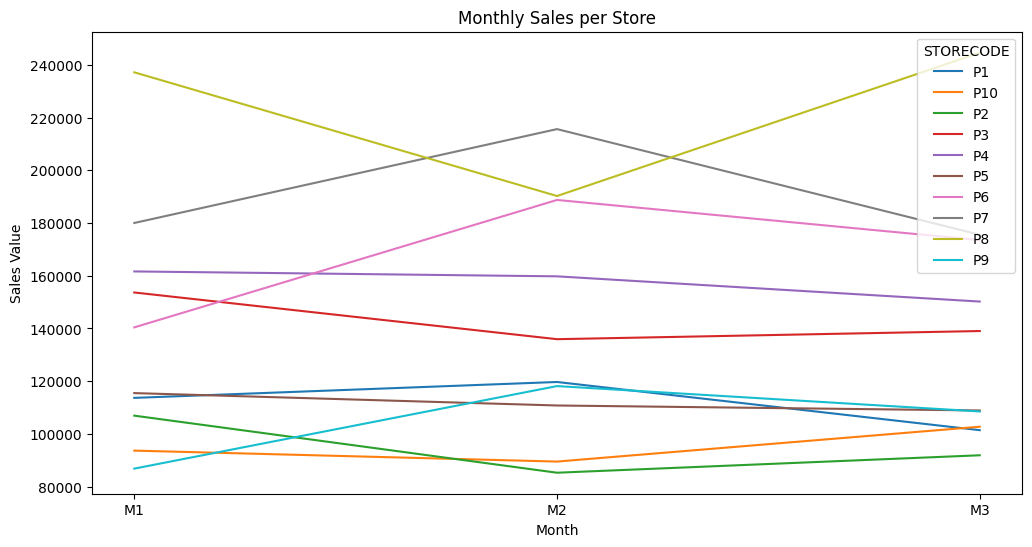

In [65]:
# Plotting sales trends
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_sales, x='MONTH', y='VALUE', hue='STORECODE')
plt.title('Monthly Sales per Store')
plt.xlabel('Month')
plt.ylabel('Sales Value')
plt.show()

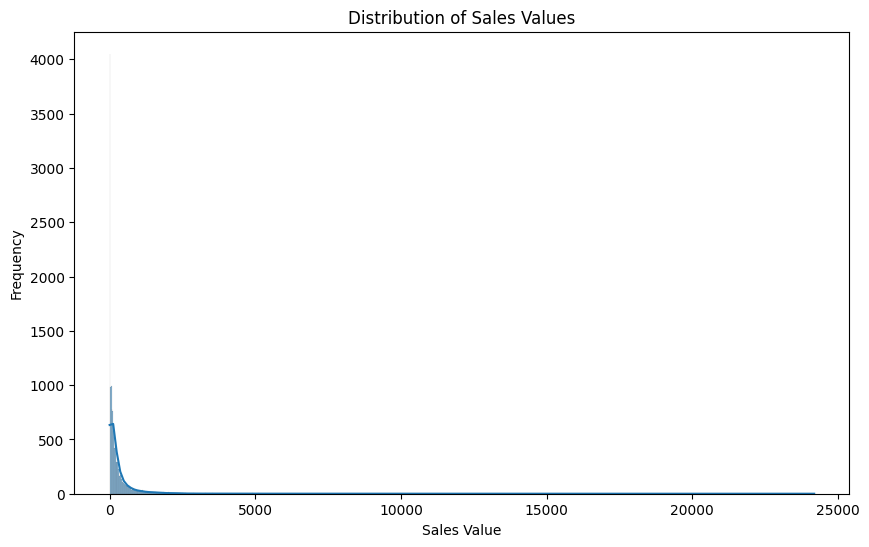

In [66]:
# Distribution of sales values
plt.figure(figsize=(10, 6))
sns.histplot(ideal_data['VALUE'], kde=True)
plt.title('Distribution of Sales Values')
plt.xlabel('Sales Value')
plt.ylabel('Frequency')
plt.show()

Predicting Missing Values

In [67]:
# Prepare the data for training
X_train = ideal_data[['MONTH', 'STORECODE', 'GRP']]  # Features
y_train = ideal_data['VALUE']  # Targe

In [68]:
# Encode categorical variables in X_train
X_train = pd.get_dummies(X_train, columns=['MONTH', 'STORECODE', 'GRP'])

# Create polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)


In [69]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_poly)


In [70]:
# Hyperparameter tuning for Ridge Regression
ridge_params = {'alpha': [0.1, 1.0, 10.0, 100.0]}
ridge_grid_search = GridSearchCV(Ridge(), ridge_params, cv=5, scoring='neg_mean_absolute_error')
ridge_grid_search.fit(X_train_scaled, y_train)


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.1, 1.0, 10.0, 100.0]},
             scoring='neg_mean_absolute_error')

In [72]:
best_ridge_model = ridge_grid_search.best_estimator_
print("Best Ridge Model Alpha:", ridge_grid_search.best_params_['alpha'])

Best Ridge Model Alpha: 0.1


In [73]:
# Cross-validation
cv_scores = cross_val_score(best_ridge_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_absolute_error')
print("Cross-Validation MAE Scores:", -cv_scores)
print("Mean CV MAE:", -cv_scores.mean())

Cross-Validation MAE Scores: [289.237504   311.98357745 245.08064262 320.45366478 417.75140131]
Mean CV MAE: 316.90135803335863


In [74]:

# Prepare validation data for prediction
X_validation = validation_data[['MONTH', 'STORECODE', 'GRP']]
X_validation = pd.get_dummies(X_validation, columns=['MONTH', 'STORECODE', 'GRP'])


In [75]:
# Ensure X_validation has the same columns as X_train
X_validation = X_validation.reindex(columns=X_train.columns, fill_value=0)

# Create polynomial features for validation data
X_validation_poly = poly.transform(X_validation)


In [76]:
# Standardize the validation data
X_validation_scaled = scaler.transform(X_validation_poly)

# Predict the missing values
validation_data['PREDICTED_VALUE'] = best_ridge_model.predict(X_validation_scaled)


In [77]:
# Prepare the final submission file
sample_submission['TOTALVALUE'] = validation_data['PREDICTED_VALUE']

# Save the submission file
sample_submission.to_csv('Final_Submission.csv', index=False)


In [78]:
# Optionally, download the submission file
files.download('Final_Submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [79]:
# Evaluate on training data (for reference)
y_pred_train = best_ridge_model.predict(X_train_scaled)
print("Training MAE:", mean_absolute_error(y_train, y_pred_train))
print("Training MSE:", mean_squared_error(y_train, y_pred_train))
print("Training R²:", r2_score(y_train, y_pred_train))


Training MAE: 243.06114715490932
Training MSE: 305025.5345258319
Training R²: 0.47205168054060986


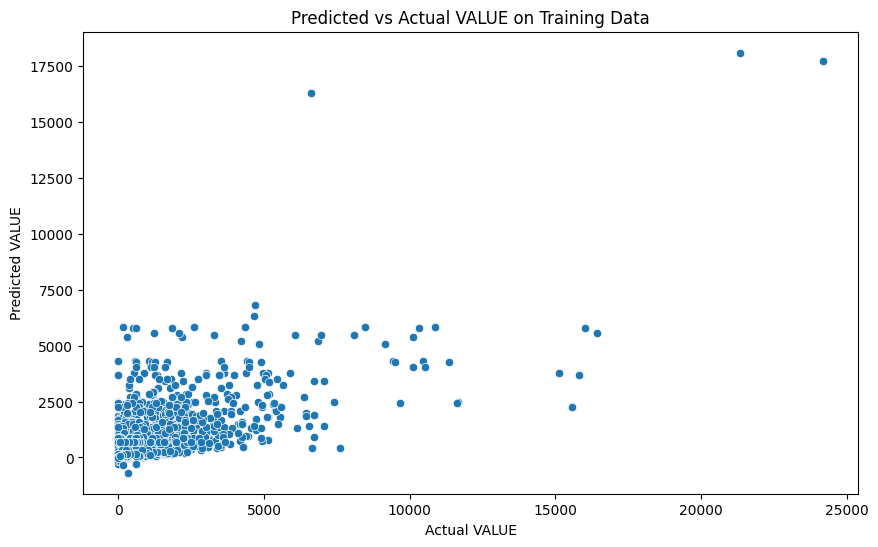

In [80]:
# Plot Predicted vs Actual on Training Data
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_train, y=y_pred_train)
plt.xlabel('Actual VALUE')
plt.ylabel('Predicted VALUE')
plt.title('Predicted vs Actual VALUE on Training Data')
plt.show()

In [81]:
# Additional Models
# Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X_train, y_train)


RandomForestRegressor()

In [82]:
# Gradient Boosting Regressor
gbr_model = GradientBoostingRegressor(n_estimators=100)
gbr_model.fit(X_train, y_train)

# Evaluate Random Forest and Gradient Boosting on training data
y_pred_rf = rf_model.predict(X_train)
y_pred_gbr = gbr_model.predict(X_train)

In [83]:
print("Random Forest Training MAE:", mean_absolute_error(y_train, y_pred_rf))
print("Random Forest Training MSE:", mean_squared_error(y_train, y_pred_rf))
print("Random Forest Training R²:", r2_score(y_train, y_pred_rf))

print("Gradient Boosting Training MAE:", mean_absolute_error(y_train, y_pred_gbr))
print("Gradient Boosting Training MSE:", mean_squared_error(y_train, y_pred_gbr))
print("Gradient Boosting Training R²:", r2_score(y_train, y_pred_gbr))

Random Forest Training MAE: 233.64485624291592
Random Forest Training MSE: 283011.3506931091
Random Forest Training R²: 0.5101545606054649
Gradient Boosting Training MAE: 262.38678312343296
Gradient Boosting Training MSE: 321595.1773460345
Gradient Boosting Training R²: 0.4433723927735478
